In [1]:
import warnings
warnings.filterwarnings('ignore')

%load_ext rpy2.ipython

%run ../notebook-init.py

# load R libraries                                                                                    
%R invisible(library(ggplot2))
%R invisible(library(fastcluster))
%R invisible(library(reshape))
%R invisible(library(reshape2))
%R invisible(library(gplots))
%R invisible(library(RSQLite))

#set up ggplot2 defaults                                                                              
%R theme_set(theme_gray(base_size=18))

%pylab inline
pylab.rcParams['figure.figsize'] = (20, 20)



Populating the interactive namespace from numpy and matplotlib


In [34]:
import gzip

mockfiles = [
    '/gfs/work/ddanko/taxonomic_profiler_comparison/analysis/actual/mock-a/setA1-1.fq.gz',
    '/gfs/work/ddanko/taxonomic_profiler_comparison/analysis/actual/mock-a/setA2-1.fq.gz',
    '/gfs/work/ddanko/taxonomic_profiler_comparison/analysis/actual/mock-a/setA3-1.fq.gz',
    '/gfs/work/ddanko/taxonomic_profiler_comparison/analysis/actual/mock-b/setB1-1.fq.gz',
    '/gfs/work/ddanko/taxonomic_profiler_comparison/analysis/actual/mock-b/setB2-1.fq.gz',
    '/gfs/work/ddanko/taxonomic_profiler_comparison/analysis/actual/mock-b/setB3-1.fq.gz',
    
]

mockproportions = {}
for mockf in mockfiles:
    thismock = {}
    with gzip.open(mockf) as mf:
        for i,line in enumerate(mf):
            if i % 4 == 0:
                id = line.split('_')
                if len(id) == 3:
                    id = id[1]
                else:
                    id = id[-2]
                if id not in thismock:
                    thismock[id] = 0
                thismock[id] += 1
    mockproportions[mockf] = thismock
    

In [123]:
mProps = {}
for k,v in mockproportions.items():
    name = k.split('/')[-1].split('.')[0]
    mProps[name] = v

In [124]:
import gzip
import glob


def processFile(f):
    out = {}
    with gzip.open(f) as kf:
        kf.readline()
        for line in kf:
            line = line.split()
            out[line[0].strip()] = int(line[1])
    return out

def main(files):
    
    kProps = {}
    for f in files:
        out = processFile(f)
        name = f.split('/')[-1].split('.')[0]
        kProps[name] = out
    return kProps



files = glob.glob('../mock/setA/kraken/*.tsv.gz')
kProps = main(files)

In [125]:
import gzip
import glob


def processFile(f):
    out = {}
    with gzip.open(f) as kf:
        kf.readline()
        for line in kf:
            line = line.split()
            out[line[0].strip()] = int(line[1])
    return out

def main(files):
    
    kProps = {}
    for f in files:
        out = processFile(f)
        name = f.split('/')[-1].split('.')[0]
        kProps[name] = out
    return kProps



files = glob.glob('../mock/setA/dmnd-fast/*.tsv.gz')
dProps = main(files)

In [126]:
import gzip
import glob


def processFile(f):
    out = {}
    with open(f) as kf:
        kf.readline()
        for line in kf:
            line = line.split()
            if len(line[0].split('|')) == 2:
                k = line[0].split('|')[1].split('__')[1]
                out[k] = float(line[1])
    return out

def main(files):
    
    pProps = {}
    for f in files:
        out = processFile(f)
        name = f.split('/')[-1].split('.')[0]
        pProps[name] = out
    return pProps



files = glob.glob('../mock/setA/mphlan/*.tsv')
pProps = main(files)


In [147]:
import math

def logOdds(A,B,intersect=False):
    slo = 0 
    aN = float(sum(A.values()))
    bN = float(sum(B.values()))
    if intersect:
        items = set(A.keys()) & set(B.keys())
    else:
        items = set(A.keys()) | set(B.keys())

    for k in items:
        if k in A:
            a = A[k] / aN
        else:
            a = 0.000001
        if k in B:
            b = B[k] / bN
        else:
            b = 0.000001
        slo += abs(math.log(a/b))
    return slo
        
    

In [148]:
kSLO = {}

for kName, kSet in kProps.items():
    mSet = mProps[kName]
    slo = logOdds(kSet,mSet)
    sloI = logOdds(kSet,mSet,intersect=True)
    kSLO[kName] = (slo,sloI)
kSLO

{'setA1-1': (112.45605531560561, 5.319373040732865),
 'setA2-1': (109.10731942166358, 5.321197592924918),
 'setA3-1': (114.78276808277116, 5.320803509234568)}

In [149]:
dSLO = {}

for dName, dSet in dProps.items():
    mSet = mProps[dName]
    slo = logOdds(dSet,mSet)
    sloI = logOdds(dSet,mSet,intersect=True)
    dSLO[dName] = (slo,sloI)
dSLO

{'setA1-1': (191.4206824336394, 4.569518709613055),
 'setA2-1': (192.60419985091957, 4.561520091517437),
 'setA3-1': (190.04755567303644, 4.567753909457832)}

In [150]:
pSLO = {}

for pName, pSet in pProps.items():
    mSet = mProps[pName]
    slo = logOdds(pSet,mSet)
    sloI = logOdds(pSet,mSet,intersect=True)
    pSLO[pName] = (slo,sloI)
pSLO

{'setA1-1': (96.86292822979848, 7.410254380699126),
 'setA2-1': (101.23120143048733, 7.362521408883285),
 'setA3-1': (100.51674043726798, 7.30320016283023)}

In [194]:
import pandas as pd

allKeys = set(mProps.keys()) | set(pProps.keys()) | set(kProps.keys()) | set(dProps.keys())


a1 = pd.DataFrame([mProps['setA1-1'],pProps['setA1-1'],kProps['setA1-1'],dProps['setA1-1']]).transpose()
a1.columns = ['actual','metaphlan','kraken','dmnd']
a1 = a1.fillna(0)

a2 = pd.DataFrame([mProps['setA2-1'],pProps['setA2-1'],kProps['setA2-1'],dProps['setA2-1']]).transpose()
a2.columns = ['actual','metaphlan','kraken','dmnd']
a2 = a2.fillna(0)

a3 = pd.DataFrame([mProps['setA3-1'],pProps['setA3-1'],kProps['setA3-1'],dProps['setA3-1']]).transpose()
a3.columns = ['actual','metaphlan','kraken','dmnd']
a3 = a3.fillna(0)

print(a1.head())
print(a2.head())


                            actual  metaphlan     kraken       dmnd
Acidobacteria            3440619.0   14.47035  3411925.0  2415589.0
Actinobacteria           2631062.0   12.19163  2608543.0        0.0
Actinobacteria_<phylum>        0.0    0.00000        0.0  1950003.0
Aquificae                      0.0    0.00000       21.0        0.0
Aquificae_<phylum>             0.0    0.00000        0.0     2734.0
                            actual  metaphlan     kraken       dmnd
Acidobacteria            3407178.0   14.38538  3377120.0  2394821.0
Actinobacteria           2605489.0   12.37805  2581533.0        0.0
Actinobacteria_<phylum>        0.0    0.00000        0.0  1930464.0
Aquificae                      0.0    0.00000       10.0        0.0
Aquificae_<phylum>             0.0    0.00000        0.0     2622.0


[1] 21
[1] 8
[1] 8
[1] 6
[1] 3
[1] 6


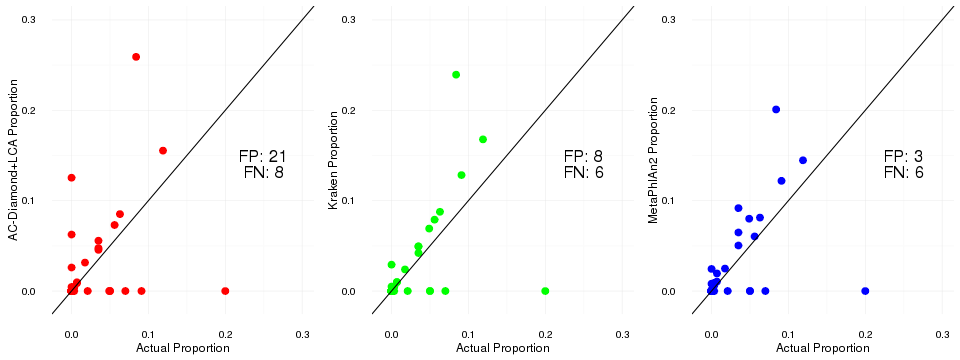

In [219]:
%%R -i a1,a2,a3 -w 960 -h 360

a1 <- sweep(a1,2,colSums(a1),function(el,n) el/n)
    
ploto <- function(tool,col,ylab){
    
    fp <- sum(a1[,tool] > 0.000001 & a1[,'actual'] < 0.000001)
    print(fp)
    fn <- sum(a1[,tool] < 0.000001 & a1[,'actual'] > 0.000001)
    print(fn)
    
    da1<-ggplot(a1,aes_string(x='actual',y=tool))+
        geom_point(size=3,color=col)+
        xlim(-0.01,0.3)+
        ylim(-0.01,0.3)+
        geom_abline()+
        labs(x='Actual Proportion',y=ylab)+
        theme_minimal()+
        annotate("text",x=0.25,y=0.15,size=6,label=sprintf("FP: %d",fp))+
        annotate("text",x=0.25,y=0.132,size=6,label=sprintf("FN: %d",fn))
    
    return(da1)
    
}
    

# da1<-ggplot(a1,aes(x=actual,y=dmnd))+
#         geom_point(size=3,color='red')+
#         xlim(-0.01,0.3)+
#         ylim(-0.01,0.3)+
#         geom_abline()+
#         labs(x='Actual Proportion',y='AC-Diamond+LCA Proportion')+
#         theme_minimal()
   
da1 <- ploto('dmnd','red','AC-Diamond+LCA Proportion')
ka1 <- ploto('kraken','green','Kraken Proportion')
ma1 <- ploto('metaphlan', 'blue','MetaPhlAn2 Proportion')
    
# ka1<-ggplot(a1,aes(x=actual,y=kraken))+
#         geom_point(size=3,color='green')+
#         xlim(-0.01,0.3)+
#         ylim(-0.01,0.3)+
#         geom_abline()+
#         labs(x='Actual Proportion',y='Kraken Proportion')+
#         theme_minimal()
    
# ma1<-ggplot(a1,aes(x=actual,y=metaphlan))+
#         geom_point(size=3,color='blue')+
#         xlim(-0.01,0.3)+
#         ylim(-0.01,0.3)+
#         geom_abline()+
#         labs(x='Actual Proportion',y='MetaPhlAn2 Proportion')+
#         theme_minimal()
    
    
grid.arrange(da1,ka1,ma1, ncol=3)


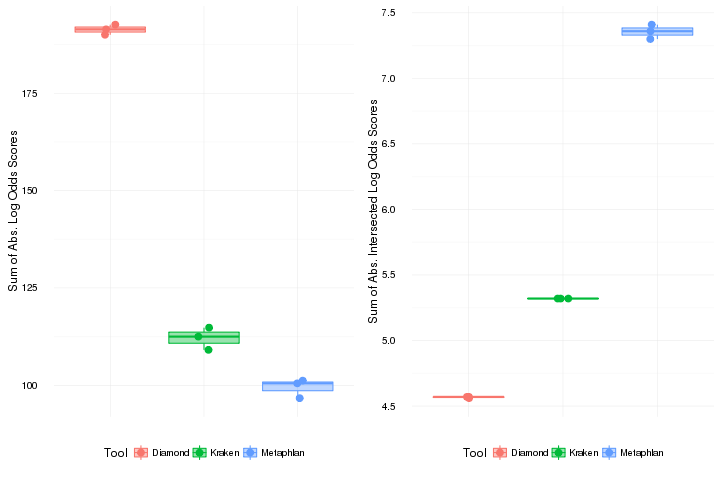

In [142]:
%%R -w 720

library(gridExtra)

kslo <- c(112.5,109.1,114.8)
dslo <- c(191.4,192.6,190.0)
mslo <- c(96.7,101.2,100.5)

ksloI <- c(5.32,5.32,5.32)
dsloI <- c(4.57,4.56,4.57)
msloI <- c(7.41,7.36,7.30)

stbl <- data.frame(
            Tool=c(rep('Kraken',3),rep('Diamond',3),rep('Metaphlan',3)), 
            slo=c(kslo,dslo,mslo),
            sloI=c(ksloI,dsloI,msloI)
)
p <- ggplot(stbl,aes(x=Tool,y=slo,fill=Tool,color=Tool)) + 
        geom_boxplot(alpha=0.4) +
        geom_point(position=position_jitterdodge(),size=3) +
        theme_minimal() +
        ylab("Sum of Abs. Log Odds Scores") + 
        theme(axis.text.x =element_blank(),axis.title.x=element_blank(), legend.position="bottom") +
        scale_fill_discrete("Tool")

pI <- ggplot(stbl,aes(x=Tool,y=sloI,fill=Tool,color=Tool)) + 
        geom_boxplot(alpha=0.4) +
        geom_point(position=position_jitterdodge(),size=3) +
        theme_minimal() +
        ylab("Sum of Abs. Intersected Log Odds Scores") + 
        theme(axis.text.x =element_blank(),axis.title.x=element_blank(), legend.position="bottom") +
        scale_fill_discrete("Tool")


grid.arrange(p,pI,ncol=2)